In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pylab as plt
import mcmc_util
import numpy as np
from multiprocessing import Pool
import copy
import pandas as pd
import os



# Load theoretical results

In [2]:
# load asymptotic variance
asymp_var_array = np.load("./simulation_results/asympt_var.npy", allow_pickle=True)

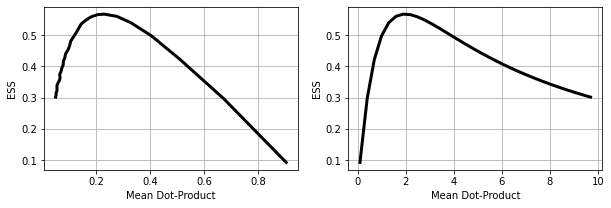

In [3]:
kappa_list_th = asymp_var_array[:,0]
dot_product_list_th = asymp_var_array[:,1]
velocity_list_th = asymp_var_array[:,2]


plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(dot_product_list_th, velocity_list_th, "k-", linewidth=3)
plt.ylabel("ESS")
plt.xlabel("Mean Dot-Product")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(kappa_list_th, velocity_list_th, "k-", linewidth=3)
plt.ylabel("ESS")
plt.xlabel("Mean Dot-Product")
plt.grid(True)


# Gaussian Examples

In [4]:
def load_result(filename):  
    """ load simulations from numpy file """
    results = np.load(filename, allow_pickle=True)
    result_dict = {"delta_list": results[:,0],
                    "kappa_list": results[:,1],
                    "ess_list": results[:,2],
                    "mean_dot_list": results[:,3],
                    "step_list": results[:,4],
                    "acceptance_list": results[:,5],
                    "DR_acceptance_list": results[:,6]}
    return result_dict

In [5]:
data_dinf = pd.read_csv("./simulation_cpp/dinf.csv", header=None)
print(data_dinf)

         0           1                   2                  3    4
0      d=5   delta=0.1   alphastd=0.960664   alphadr=0.993975     
1      d=5   delta=0.1   alphastd=0.960507   alphadr=0.994049  NaN
2      d=5   delta=0.1    alphastd=0.96041    alphadr=0.99366  NaN
3     d=10   delta=0.1   alphastd=0.960406   alphadr=0.996338  NaN
4     d=10   delta=0.1   alphastd=0.960392   alphadr=0.996314  NaN
..     ...         ...                 ...                ...  ...
100  d=200   delta=0.5   alphastd=0.802689   alphadr=0.998368  NaN
101  d=200   delta=0.5   alphastd=0.802859   alphadr=0.998367     
102  d=200   delta=0.2   alphastd=0.920511   alphadr=0.999623  NaN
103  d=200   delta=0.2    alphastd=0.92038   alphadr=0.999636  NaN
104  d=200   delta=0.2   alphastd=0.919996   alphadr=0.999463  NaN

[105 rows x 5 columns]


In [6]:
dinf_dict = {
    "dim": [int(_.split("=")[1]) for _ in data_dinf[0].values],
    "delta": [float(_.split("=")[1]) for _ in data_dinf[1].values],
    "alphastd": [float(_.split("=")[1]) for _ in data_dinf[2].values],
    "alphadr": [float(_.split("=")[1]) for _ in data_dinf[3].values] }


<Figure size 432x288 with 0 Axes>

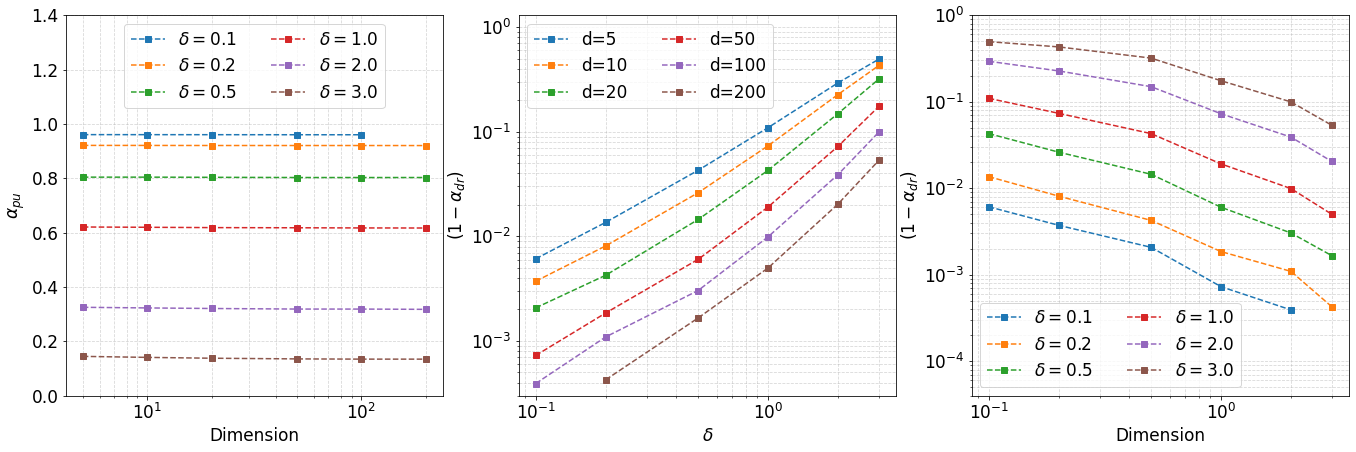

In [7]:
font = {'size'   : 17}
plt.rc('font', **font)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig = plt.figure(figsize=(23,7))

plt.subplot(1,3,1)
delta_unique = np.unique(dinf_dict["delta"])
for delta in delta_unique:
    alphastd_list = []    
    for dim in np.unique(dinf_dict["dim"]):
        #print(dim, delta)
        alphastd_local = [alphastd_ for alphastd_, dim_, delta_ in zip(dinf_dict["alphastd"], dinf_dict["dim"], dinf_dict["delta"]) if dim_==dim and delta_ == delta]
        if len(alphastd_local) >= 1:
            alphastd_list.append(np.mean(alphastd_local))
        else:
            alphastd_list.append(np.nan)
    plt.plot(np.unique(dinf_dict["dim"]), np.array(alphastd_list), "s--", label=r"$\delta=${}".format(delta))
    plt.legend(loc=9, ncol=2)#, borderaxespad=0.)
    plt.xscale("log")
    plt.grid(True,which="both", linestyle="--", alpha=0.5)
    plt.ylim(0., 1.4)
    plt.xlabel("Dimension")
    plt.ylabel(r"$\alpha_{pu}$")
    
    
plt.subplot(1,3,2)
for dim in np.unique(dinf_dict["dim"]):
    delta_unique = np.unique(dinf_dict["delta"])
    alphadr_list = []    
    for delta in delta_unique:
        #print(dim, delta)
        alphadr_local = [alphastd_ for alphastd_, dim_, delta_ in zip(dinf_dict["alphadr"], dinf_dict["dim"], dinf_dict["delta"]) if dim_==dim and delta_ == delta]
        if len(alphadr_local) >= 1:
            alphadr_list.append(np.mean(alphadr_local))
        else:
            alphadr_list.append(np.nan)
    plt.plot(delta_unique, 1.-np.array(alphadr_list), "s--", label="d={}".format(dim))
    plt.xlabel(r"$\delta$")
    plt.ylabel(r"$(1 - \alpha_{dr})$")    
    plt.legend(ncol=2)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(3*10**-4, 1.3)
    plt.grid(True,which="both", linestyle="--", alpha=0.5)
    
    
plt.subplot(1,3,3)
delta_unique = np.unique(dinf_dict["delta"])
for delta in delta_unique:
    alphadr_list = []        
    for dim in np.unique(dinf_dict["dim"]):
        #print(dim, delta)
        alphadr_local = [alphastd_ for alphastd_, dim_, delta_ in zip(dinf_dict["alphadr"], dinf_dict["dim"], dinf_dict["delta"]) if dim_==dim and delta_ == delta]
        if len(alphadr_local) >= 1:
            alphadr_list.append(np.mean(alphadr_local))
        else:
            alphadr_list.append(np.nan)
    plt.plot(delta_unique, 1.-np.array(alphadr_list), "s--", label=r"$\delta=${}".format(delta))
    plt.xlabel("Dimension")
    plt.ylabel(r"$(1 - \alpha_{dr})$")    
    plt.legend(ncol=2)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(4*10**-5, 1)
    plt.grid(True,which="both", linestyle="--", alpha=0.5)
    
fig.savefig("./simulation_figures/study_alpha_DR_std.pdf", layout="tight")

In [8]:
data_cvg = pd.read_csv("./simulation_cpp/Cvgd50from10_.csv", header=None)
data_cvg = data_cvg.values

In [9]:
data_cvg_percentile = np.percentile(data_cvg, q = [1,50,99], axis=0)
kappa_cvg = [.04,.1,.2,.4,1,2,3]
meandots_cvg = [0.938,0.852,0.728,0.540,0.247,0.080,0.026]

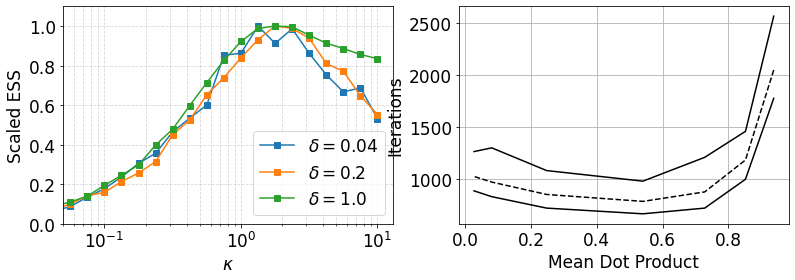

In [10]:
fig = plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
dim=100
delta=0.04
filename = f"iso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
dbps_stats_004 = load_result(filename)

dim=100
delta=0.2
filename = f"iso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
dbps_stats_02 = load_result(filename)


dim=100
delta=1.0
filename = f"iso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
dbps_stats_1 = load_result(filename)


plt.plot(dbps_stats_004["kappa_list"], dbps_stats_004["ess_list"] / np.max(dbps_stats_004["ess_list"]), "-s", label=r"$\delta=0.04$" )
plt.plot(dbps_stats_02["kappa_list"], dbps_stats_02["ess_list"] / np.max(dbps_stats_02["ess_list"]), "-s", label=r"$\delta=0.2$" )
plt.plot(dbps_stats_1["kappa_list"], dbps_stats_1["ess_list"] / np.max(dbps_stats_1["ess_list"]), "-s", label=r"$\delta=1.0$" )


#plt.plot(kappa_list_th, velocity_list_th / np.max(velocity_list_th), "k-", linewidth=3, label="Isotropic Theory" )

plt.xlabel(r"$\kappa$")
plt.ylabel("Scaled ESS")

plt.xscale("log")
plt.ylim(0,1.1)
plt.xlim(0.05,13)
plt.grid(True,which="both", linestyle="--", alpha=0.5)
plt.legend()

plt.subplot(1,2,2)
plt.plot(meandots_cvg, data_cvg_percentile[0,:], "k-")
plt.plot(meandots_cvg, data_cvg_percentile[1,:], "k--")
plt.plot(meandots_cvg, data_cvg_percentile[2,:], "k-")
plt.grid(True)
plt.xlabel("Mean Dot Product")
plt.ylabel("Iterations")

fig.savefig("./simulation_figures/study_tail_and_delta.pdf", layout="tight")

# Approximate gradient

In [11]:
data_mmpp = pd.read_csv("./simulation_cpp/mmppcycA0R1.csv")
data_mmpp_pre = pd.read_csv("./simulation_cpp/mmppcycA1.csv")
print(data_mmpp)
print("\n")
print(data_mmpp_pre)

    delta  kappa  udotmean  ESSlp  udotmeand3  ESSlpd3
0    0.04    0.4    0.9580    942      0.9580      449
1    0.04    1.0    0.8980   1372      0.9000      483
2    0.04    2.0    0.8070   1974      0.8090      634
3    0.04    3.0    0.7280   2039      0.7270      744
4    0.04    4.0    0.6560   2260      0.6590      753
5    0.04    7.0    0.4870   2380      0.4850      808
6    0.04   10.0    0.3720   2298      0.3710      836
7    0.04   14.0    0.2640   2217      0.2620      851
8    0.04   17.0    0.2100   2229      0.2130      895
9    0.04   20.0    0.1620   1868      0.1630      742
10   0.04   28.0    0.0873   1491      0.0851      704
11   0.04   40.0    0.0139   1349      0.0209      530
12   0.04  100.0   -0.0859    900     -0.0857      404
13   0.04  200.0   -0.1110    868     -0.1120      328


    delta  kappa  udotmean  ESSlp
0    0.04    0.4    0.9580    489
1    0.04    1.0    0.8980    773
2    0.04    2.0    0.8060   1202
3    0.04    3.0    0.7260   1543
4  

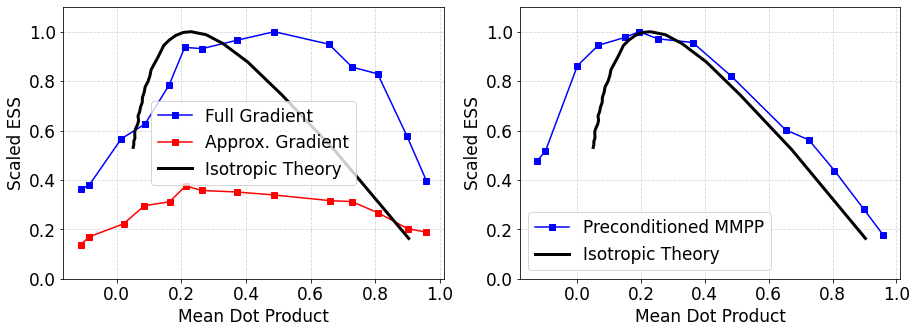

In [14]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
max_ess = np.max(data_mmpp["ESSlp"])
plt.plot(data_mmpp["udotmean"], data_mmpp["ESSlp"]/max_ess, "b-s", label="Full Gradient")
plt.plot(data_mmpp["udotmeand3"], data_mmpp["ESSlpd3"]/max_ess, "r-s", label="Approx. Gradient")
plt.plot(dot_product_list_th, velocity_list_th / np.max(velocity_list_th), "k-", linewidth=3, label="Isotropic Theory" )
plt.grid(True,which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.ylim(0,1.1)
plt.xlabel("Mean Dot Product")
plt.ylabel("Scaled ESS")

plt.subplot(1,2,2)
max_ess = np.max(data_mmpp_pre["ESSlp"])
plt.plot(data_mmpp_pre["udotmean"], data_mmpp_pre["ESSlp"]/max_ess, "b-s", label="Preconditioned MMPP")
plt.plot(dot_product_list_th, velocity_list_th / np.max(velocity_list_th), "k-", linewidth=3, label="Isotropic Theory" )
plt.grid(True,which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.ylim(0,1.1)
plt.xlabel("Mean Dot Product")
plt.ylabel("Scaled ESS")
fig.savefig("./simulation_figures/study_MMPP.pdf")



